## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Data Gathering

In [17]:
raw = pd.read_csv('Bank_Customer_Segmentation_final.csv')
raw.head()

,Unnamed: 0,CustomerID,Age,Gender,MaritalStatus,EducationLevel,Dependents,Location,Occupation,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,0,1.0,72.0,NaN,Married,Bachelor's,2.0,SemiUrban,Retired,NaN,215659.0,5.0,14037.0,Low,Low,Mid-term,Low,Negative,FD
1,1,2.0,24.0,Female,Single,Bachelor's,0.0,Metro,Homemaker,737.0,209181.0,20.0,45046.0,High,Low,Short-term,Medium,Neutral,Credit Card
2,2,3.0,60.0,Female,Married,High School,0.0,Metro,Retired,556.0,165066.0,4.0,13727.0,Low,Medium,Mid-term,Medium,Negative,SIP
3,3,4.0,52.0,Male,Married,Bachelor's,2.0,SemiUrban,Retired,785.0,40493.0,7.0,30050.0,Medium,Medium,Mid-term,Medium,Negative,SIP
4,4,5.0,29.0,NaN,Married,High School,NaN,SemiUrban,Business,560.0,25745.0,26.0,46967.0,High,High,Long-term,Medium,Positive,Credit Card


In [18]:
raw.drop(['Unnamed: 0','CustomerID'], axis = 1, inplace=True)

In [19]:
cat_col = [col for col in raw.columns if raw[col].dtypes == 'object']
num_col = [col for col in raw.columns if raw[col].dtypes == 'float64']

## EDA

In [20]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154893 entries, 0 to 154892
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           147047 non-null  float64
 1   Gender                        147118 non-null  object 
 2   MaritalStatus                 147128 non-null  object 
 3   EducationLevel                147316 non-null  object 
 4   Dependents                    147110 non-null  float64
 5   Location                      147256 non-null  object 
 6   Occupation                    147124 non-null  object 
 7   CreditScore                   147175 non-null  float64
 8   MonthlyAverageBalance         147176 non-null  float64
 9   NumberOfTransactionsPerMonth  147264 non-null  float64
 10  AverageTransactionValue       147086 non-null  float64
 11  OnlineBankingUsage            147140 non-null  object 
 12  ATMUsage                      147095 non-nul

In [21]:
raw.describe(include='float64')

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue
count,147047.000000,147110.000000,147175.000000,1.471760e+05,147264.000000,1.470860e+05
mean,56.367046,1.726477,763.172726,1.863282e+05,15.385390,4.559762e+04
std,68.278956,1.562315,849.789822,2.551460e+05,27.525505,6.596102e+04
min,18.000000,0.000000,450.000000,5.003000e+03,2.000000,8.000000e+03
25%,32.000000,0.000000,539.000000,8.075425e+04,5.000000,1.851700e+04
50%,47.000000,1.000000,630.000000,1.561440e+05,7.000000,2.837150e+04
75%,62.000000,3.000000,720.000000,2.321800e+05,15.000000,5.546750e+04
max,888.000000,5.000000,9600.000000,3.597024e+06,600.000000,1.199376e+06


In [22]:
raw.describe(include='object')

,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
count,147118,147128,147316,147256,147124,147140,147095,146907,147167,147018,147378
unique,2,2,4,3,7,3,3,3,3,3,4
top,Male,Married,Bachelor's,Metro,Retired,Medium,Medium,Mid-term,Medium,Positive,SIP
freq,85284,114069,75121,49308,66968,63841,59988,90070,72844,49327,37170


## Outlier Detection

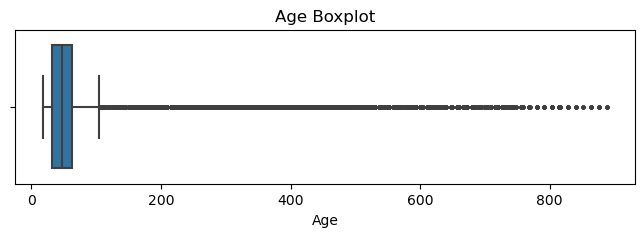

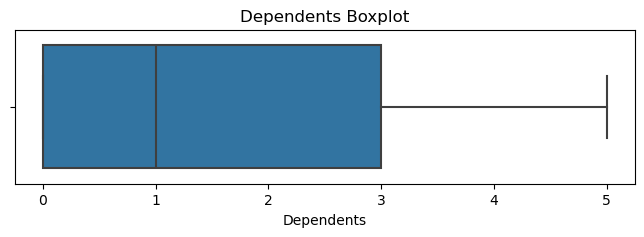

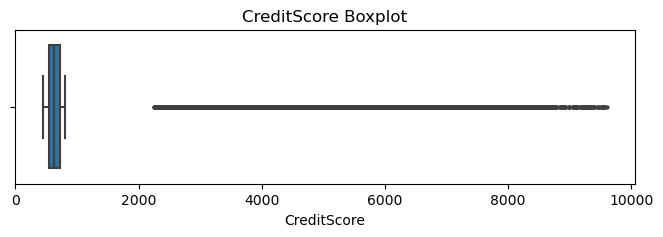

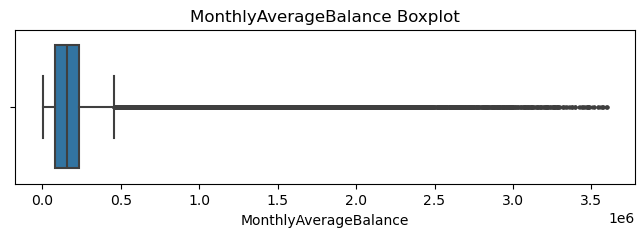

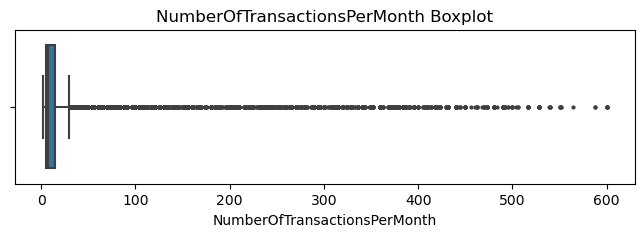

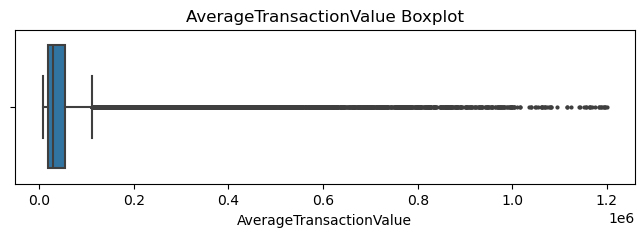

In [23]:
for col in num_col:
    plt.figure(figsize=(8,2))  # Adjusted figsize for better visualization
    sns.boxplot(x=raw[col], flierprops={'marker': 'o', 'markersize': 2})  # Using seaborn for boxplot
    plt.title(f'{col} Boxplot')
    plt.show()

In [24]:
outliers = {}
for col in num_col:
    
    a = raw[col].quantile(0.25)
    b = raw[col].quantile(0.75)
    
    iqr = b - a
    
    upper_limit = b + 1.5 * iqr
    lower_limit = a - 1.5 * iqr
    
    outlier_indices = raw.loc[(raw[col] > upper_limit) | (raw[col] < lower_limit)].index
    outliers[col] = outlier_indices

outliers

{'Age': Index([    23,    107,    193,    204,    253,    258,    265,    271,    290,
           294,
        ...
        154686, 154688, 154708, 154717, 154761, 154769, 154817, 154824, 154827,
        154868],
       dtype='int64', length=4364),
 'Dependents': Index([], dtype='int64'),
 'CreditScore': Index([    20,     60,    101,    197,    245,    253,    269,    350,    366,
           395,
        ...
        154548, 154552, 154576, 154616, 154637, 154645, 154711, 154729, 154730,
        154746],
       dtype='int64', length=4371),
 'MonthlyAverageBalance': Index([    39,     51,    181,    236,    257,    283,    332,    419,    484,
           578,
        ...
        154669, 154693, 154773, 154775, 154783, 154807, 154810, 154819, 154848,
        154882],
       dtype='int64', length=3600),
 'NumberOfTransactionsPerMonth': Index([     7,     22,     30,     35,     40,     42,     61,     64,     65,
            81,
        ...
        154804, 154816, 154826, 154845, 154855, 1

## Outlier Handling

In [25]:
raw['Age'] = np.where(raw['Age'] > 90, raw['Age'].median(), raw['Age'])

In [26]:
raw['CreditScore'] = np.where(raw['CreditScore'].index.isin(outliers['CreditScore']), raw['CreditScore'].median(), raw['CreditScore'])

In [27]:
a = raw['MonthlyAverageBalance'].quantile(0.25)
b = raw['MonthlyAverageBalance'].quantile(0.75)

iqr = b - a

upper_limit = b + (1.5 * iqr)

raw.loc[raw['MonthlyAverageBalance'] > upper_limit, 'MonthlyAverageBalance'] = upper_limit
upper_limit

459318.625

In [29]:
a = raw['NumberOfTransactionsPerMonth'].quantile(0.25)
b = raw['NumberOfTransactionsPerMonth'].quantile(0.75)

iqr = b - a

upper_limit = b + (3 * iqr)

raw.loc[raw['NumberOfTransactionsPerMonth'] > upper_limit, 'NumberOfTransactionsPerMonth'] = upper_limit
upper_limit

45.0

In [30]:
a = raw['AverageTransactionValue'].quantile(0.25)
b = raw['AverageTransactionValue'].quantile(0.75)

iqr = b - a

upper_limit = b + (1.5 * iqr)

raw.loc[raw['AverageTransactionValue'] > upper_limit, 'AverageTransactionValue'] = upper_limit
upper_limit

110893.25

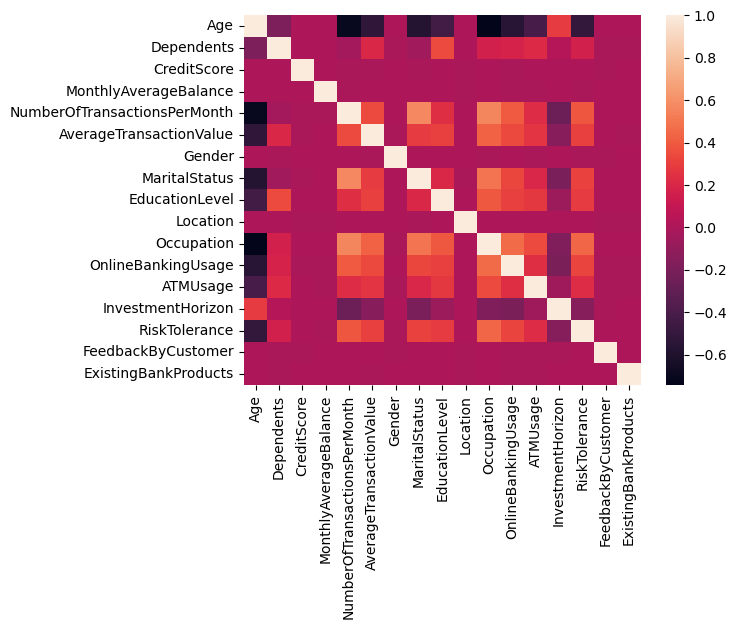

<Figure size 3500x2000 with 0 Axes>

In [21]:
## Checking for correlation in features

heatmap= sns.heatmap(final_df.corr(), annot=False)
plt.figure(figsize=(35,20))
heatmap.figure.savefig('heatmap_corr1.png')

## Handling Missing Values

In [31]:
imputer = KNNImputer(n_neighbors=5)
si= SimpleImputer(strategy='most_frequent')

In [32]:
num_imputed = pd.DataFrame(imputer.fit_transform(raw[num_col]), columns=num_col)
num_imputed.isna().sum()

Age                             0
Dependents                      0
CreditScore                     0
MonthlyAverageBalance           0
NumberOfTransactionsPerMonth    0
AverageTransactionValue         0
dtype: int64

In [33]:
cat_imputed = pd.DataFrame(si.fit_transform(raw[cat_col]), columns=cat_col)
cat_imputed.isna().sum()

Gender                  0
MaritalStatus           0
EducationLevel          0
Location                0
Occupation              0
OnlineBankingUsage      0
ATMUsage                0
InvestmentHorizon       0
RiskTolerance           0
FeedbackByCustomer      0
ExistingBankProducts    0
dtype: int64

In [34]:
imputed_df = pd.concat([cat_imputed, num_imputed], axis=1)
imputed_df.head()

,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue
0,Male,Married,Bachelor's,SemiUrban,Retired,Low,Low,Mid-term,Low,Negative,FD,72.0,2.0,601.8,215659.0,5.0,14037.0
1,Female,Single,Bachelor's,Metro,Homemaker,High,Low,Short-term,Medium,Neutral,Credit Card,24.0,0.0,737.0,209181.0,20.0,45046.0
2,Female,Married,High School,Metro,Retired,Low,Medium,Mid-term,Medium,Negative,SIP,60.0,0.0,556.0,165066.0,4.0,13727.0
3,Male,Married,Bachelor's,SemiUrban,Retired,Medium,Medium,Mid-term,Medium,Negative,SIP,52.0,2.0,785.0,40493.0,7.0,30050.0
4,Male,Married,High School,SemiUrban,Business,High,High,Long-term,Medium,Positive,Credit Card,29.0,2.0,560.0,25745.0,26.0,46967.0


In [44]:
imputed_df['MaritalStatus'].value_counts()

MaritalStatus
Married    121834
Single      33059
Name: count, dtype: int64

## Encoding the Categorical Variables

In [46]:
oe = OrdinalEncoder(
    categories=[
        ['Male', 'Female'],  # Gender categories
        ['Married', 'Single'],  # MaritalStatus categories
        ["High School", "Bachelor's", "Master's", 'PhD'],  # EducationLevel order
        ['Metro', 'Rural', 'SemiUrban'],  # Location categories
        ['Retired', 'Others', 'Homemaker', 'Self-Employed', 'Salaried', 'Business', 'Student'],  # Occupation categories
        ['Low', 'Medium', 'High'],  # OnlineBankingUsage order
        ['Low', 'Medium', 'High'],  # ATMUsage order
        ['Short-term', 'Mid-term', 'Long-term'],  # InvestmentHorizon order
        ['Low', 'Medium', 'High'],  # RiskTolerance order
        ['Negative', 'Neutral', 'Positive'], # FeedbackByCustomer order
        ['SIP', 'Loan', 'FD', 'Credit Card']  # ExistingBankProducts categories
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1,  # A specific value for unknown categories
    dtype=int
    # Ensure the output is in integer format
)

In [49]:
cat_col_trf = pd.DataFrame(oe.fit_transform(imputed_df[cat_col]), columns=cat_col)
cat_col_trf

,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,0,0,1,2,0,0,0,1,0,0,2
1,1,1,1,0,2,2,0,0,1,1,3
2,1,0,0,0,0,0,1,1,1,0,0
3,0,0,1,2,0,1,1,1,1,0,0
4,0,0,0,2,5,2,2,2,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...
154888,0,0,0,2,5,2,0,0,1,2,1
154889,0,0,1,2,5,2,2,1,1,0,1
154890,0,0,0,1,0,1,0,1,0,1,3
154891,0,0,3,2,4,2,1,0,2,2,0


In [50]:
df1 = imputed_df.copy()

In [51]:
df1.drop(cat_col, axis=1, inplace=True)
df2 = pd.concat([df1, cat_col_trf], axis=1)
df2.head(10)

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,72.0,2.0,601.8,215659.0,5.0,14037.0,0,0,1,2,0,0,0,1,0,0,2
1,24.0,0.0,737.0,209181.0,20.0,45046.0,1,1,1,0,2,2,0,0,1,1,3
2,60.0,0.0,556.0,165066.0,4.0,13727.0,1,0,0,0,0,0,1,1,1,0,0
3,52.0,2.0,785.0,40493.0,7.0,30050.0,0,0,1,2,0,1,1,1,1,0,0
4,29.0,2.0,560.0,25745.0,26.0,46967.0,0,0,0,2,5,2,2,2,1,2,3


In [ ]:
--------------------------------------------------------------------------------------------------------------------------------------------------------

## Scaling the data

In [52]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df2)
df = pd.DataFrame(df_scaled, columns=df2.columns)
df.head()

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,0.750000,0.4,0.433714,0.463678,0.069767,0.058672,0.0,0.0,0.333333,1.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.666667
1,0.083333,0.0,0.820000,0.449419,0.418605,0.360043,1.0,1.0,0.333333,0.0,0.333333,1.0,0.0,0.0,0.5,0.5,1.000000
2,0.583333,0.0,0.302857,0.352317,0.046512,0.055660,1.0,0.0,0.000000,0.0,0.000000,0.0,0.5,0.5,0.5,0.0,0.000000
3,0.472222,0.4,0.957143,0.078117,0.116279,0.214300,0.0,0.0,0.333333,1.0,0.000000,0.5,0.5,0.5,0.5,0.0,0.000000
4,0.152778,0.4,0.314286,0.045655,0.558140,0.378713,0.0,0.0,0.000000,1.0,0.833333,1.0,1.0,1.0,0.5,1.0,1.000000


In [53]:
df.to_csv('Preprocessed_df.csv',index=False)

In [32]:
final_df = pd.read_csv('Preprocessed_df.csv')
final_df

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,0.750000,0.4,0.433714,0.463678,0.069767,0.058672,0.0,0.0,0.333333,1.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.666667
1,0.083333,0.0,0.820000,0.449419,0.418605,0.360043,1.0,1.0,0.333333,0.0,0.333333,1.0,0.0,0.0,0.5,0.5,1.000000
2,0.583333,0.0,0.302857,0.352317,0.046512,0.055660,1.0,0.0,0.000000,0.0,0.000000,0.0,0.5,0.5,0.5,0.0,0.000000
3,0.472222,0.4,0.957143,0.078117,0.116279,0.214300,0.0,0.0,0.333333,1.0,0.000000,0.5,0.5,0.5,0.5,0.0,0.000000
4,0.152778,0.4,0.314286,0.045655,0.558140,0.378713,0.0,0.0,0.000000,1.0,0.833333,1.0,1.0,1.0,0.5,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154888,0.447222,0.6,0.782857,0.166842,0.093023,0.181372,0.0,0.0,0.000000,1.0,0.833333,1.0,0.0,0.0,0.5,1.0,0.333333
154889,0.208333,0.4,0.477714,0.238609,0.255814,0.102621,0.0,0.0,0.333333,1.0,0.833333,1.0,1.0,0.5,0.5,0.0,0.333333
154890,0.513889,0.4,0.306857,0.093391,0.093023,0.085059,0.0,0.0,0.000000,0.5,0.000000,0.5,0.0,0.5,0.0,0.5,1.000000
154891,0.208333,0.8,0.965714,0.267556,0.069767,0.544506,0.0,0.0,1.000000,1.0,0.666667,1.0,0.5,0.0,1.0,1.0,0.000000


In [ ]:
-------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [39]:
sil_scores = []
wcss_list = []
davies_b_indices = []
ch_indices = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans_model = KMeans(n_clusters=k, random_state=11)
    kmeans_model.fit(final_df)
    wcss_list.append(round(kmeans_model.inertia_,2))
    sil_scores.append(round(silhouette_score(final_df, kmeans_model.labels_),2))
    davies_b_indices.append(round(davies_bouldin_score(final_df, kmeans_model.labels_),2))
    ch_indices.append(round(calinski_harabasz_score(final_df, kmeans_model.labels_),2))

In [47]:
k_values

range(2, 16)

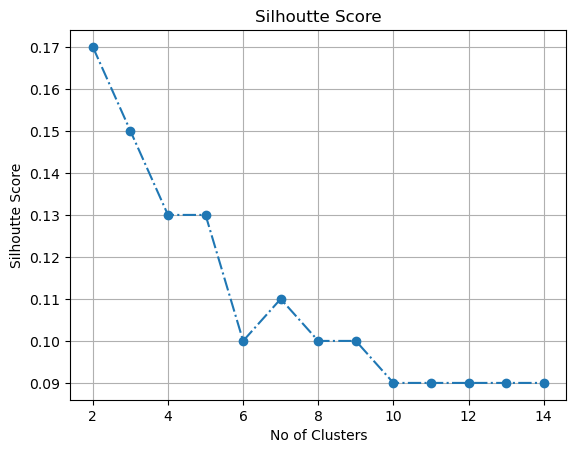

In [50]:
plt.title('Silhoutte Score')
plt.xlabel('No of Clusters')
plt.ylabel('Silhoutte Score')
plt.plot(cluster_range, sil_scores, marker = 'o', linestyle = '-.')
plt.grid(True)

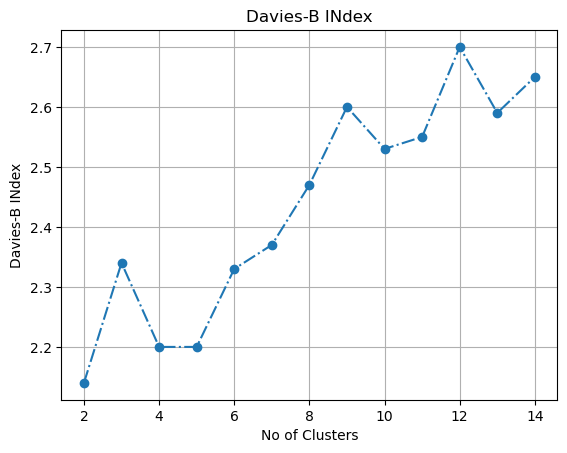

In [51]:
plt.title('Davies-B INdex')
plt.xlabel('No of Clusters')
plt.ylabel('Davies-B INdex')
plt.plot(cluster_range, davies_b_indices, marker = 'o', linestyle = '-.')
plt.grid(True)

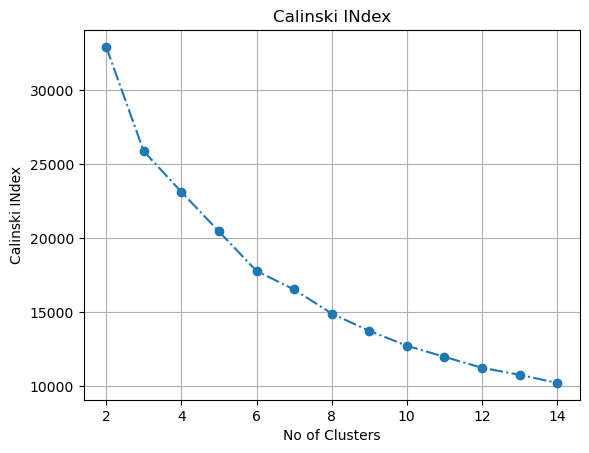

In [52]:
plt.title('Calinski INdex')
plt.xlabel('No of Clusters')
plt.ylabel('Calinski INdex')
plt.plot(cluster_range, ch_indices, marker = 'o', linestyle = '-.')
plt.grid(True)

In [54]:
cluster_results  = pd.DataFrame()
cluster_results['Cluster'] = cluster_range
cluster_results['WCSS'] = wcss_list
cluster_results['Davies-Bouldin Index'] = davies_b_indices
cluster_results['Calinski-Harabasz Index'] = ch_indices
cluster_results['Silhoutte Score'] = sil_scores
cluster_results

,Cluster,WCSS,Davies-Bouldin Index,Calinski-Harabasz Index,Silhoutte Score
0,2,253566.00,2.14,32924.54,0.17
1,3,230483.26,2.34,25866.89,0.15
2,4,212359.88,2.20,23122.41,0.13
3,5,201204.51,2.20,20450.04,0.13
4,6,195371.98,2.33,17773.09,0.10
5,7,187459.95,2.37,16525.46,0.11
6,8,183759.67,2.47,14895.36,0.10
7,9,179895.87,2.60,13729.15,0.10
8,10,176778.73,2.53,12722.21,0.09
9,11,173435.36,2.55,11969.22,0.09


In [ ]:
------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
df = pd.read_csv('Encoded.csv')
df.head()

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,72.0,2.0,601.8,215659.0,5.0,14037.0,0,0,1,2,0,0,0,1,0,0,2
1,24.0,0.0,737.0,209181.0,20.0,45046.0,1,1,1,0,2,2,0,0,1,1,3
2,60.0,0.0,556.0,165066.0,4.0,13727.0,1,0,0,0,0,0,1,1,1,0,0
3,52.0,2.0,785.0,40493.0,7.0,30050.0,0,0,1,2,0,1,1,1,1,0,0
4,29.0,2.0,560.0,25745.0,26.0,46967.0,0,0,0,2,5,2,2,2,1,2,3


## Standard Scaling

## KMeans Model with 4 clusters

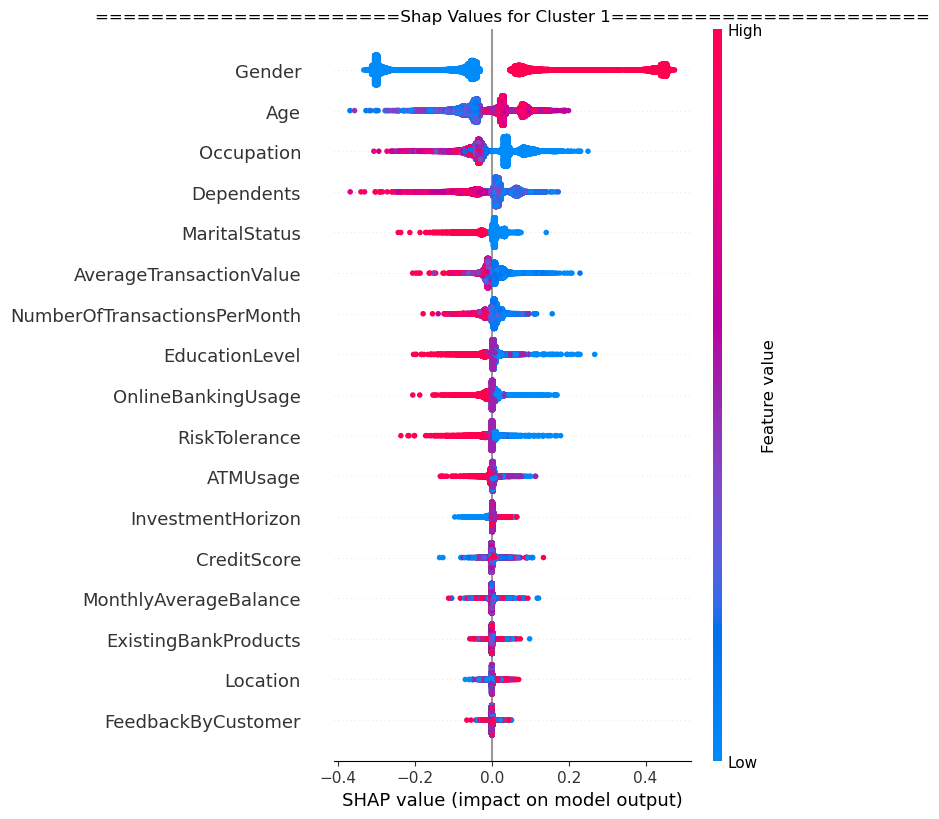

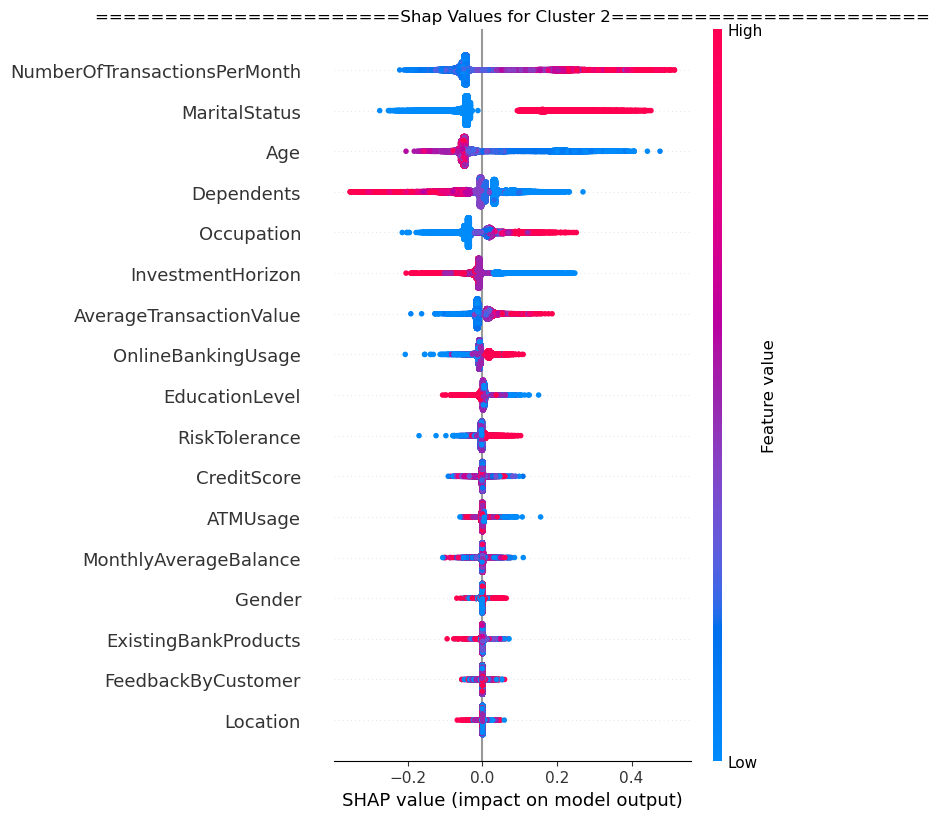

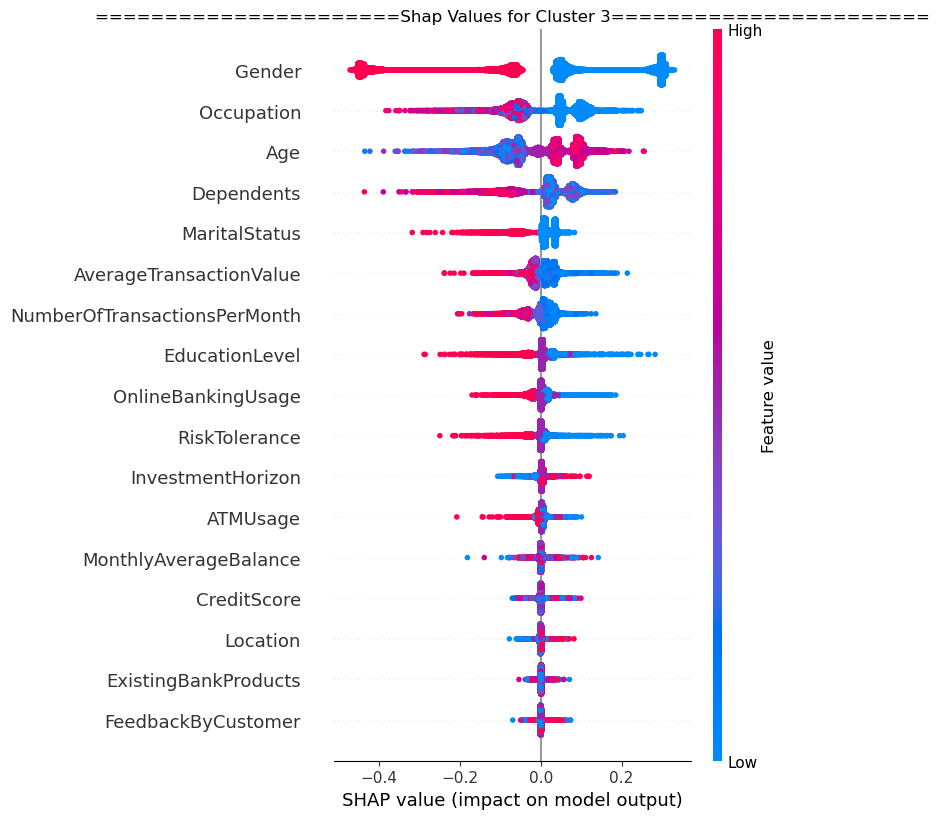

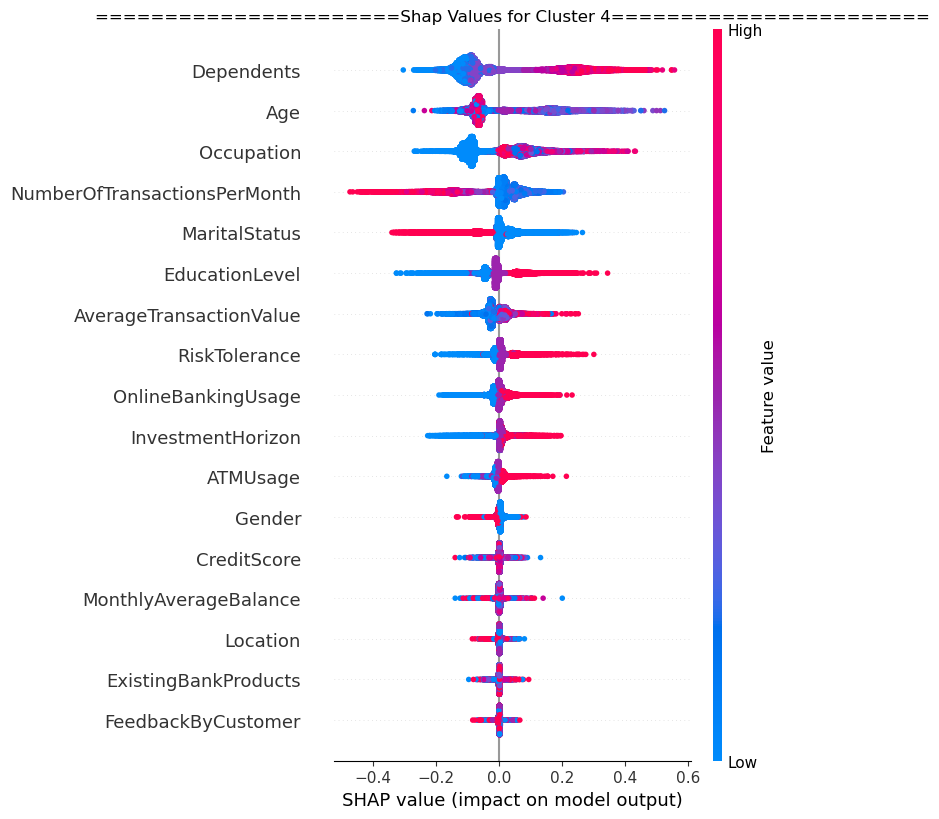

In [4]:
sa_df = df.sample(30000, random_state=30)

scale = StandardScaler()
arr_sample = scale.fit_transform(sa_df)
std_sample = pd.DataFrame(arr_sample, columns = df.columns)

kmeans_model = KMeans(n_clusters=4, random_state=30)
kmeans_model.fit(std_sample)
kmeans_model.cluster_centers_
sample_cluster = kmeans_model.predict(std_sample)
std_sample['Cluster_pred'] = sample_cluster

from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier (or any other classifier)
clf = RandomForestClassifier(n_estimators=5, random_state=30)
clf.fit(arr_sample, sample_cluster)

# Compute SHAP values
import shap 
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(arr_sample)

for cluster_indices, class_label in enumerate(['Cluster 1','Cluster 2','Cluster 3','Cluster 4']):
    plt.title(f'Shap Values for {class_label}'.center(70, '='))
    fig = shap.summary_plot(shap_values[:,:,cluster_indices], arr_sample, feature_names=std_sample.columns)
    plt.show()
    print('\n')
    plt.close()

In [ ]:
-------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
## Fitting Random Forest Tree for plotting 

from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier (or any other classifier)

clf = RandomForestClassifier(n_estimators=5, random_state=30)
clf.fit(arr_sample, sample_cluster)


In [ ]:
# Compute SHAP values

import shap 
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(arr_sample)


In [ ]:
## Plotting shap values for all features in clusters

for cluster_indices, class_label in enumerate(['Cluster 1','Cluster 2','Cluster 3','Cluster 4']):
    plt.title(f'Shap Values for {class_label}'.center(70, '='))
    fig = shap.summary_plot(shap_values[:,:,cluster_indices], arr_sample, feature_names=std_sample.columns)
    plt.show()
    print('\n')
    plt.close()

In [ ]:
-------------------------------------------------------------------------------------------------------------------------------------------------------

## MinMaxScaling

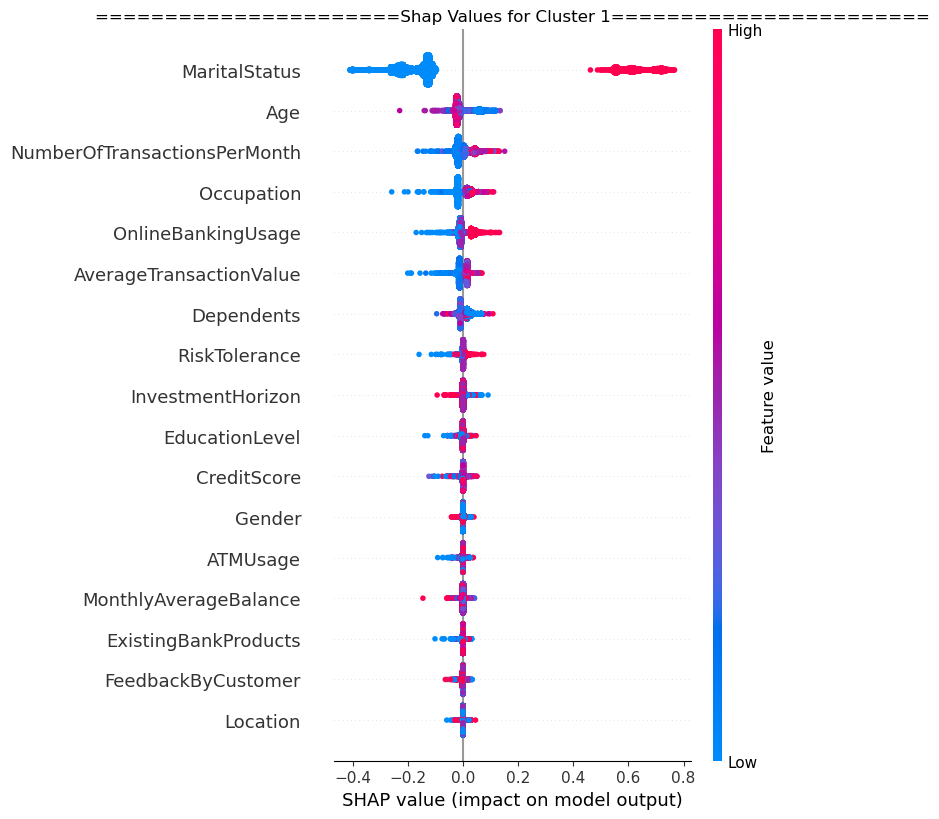

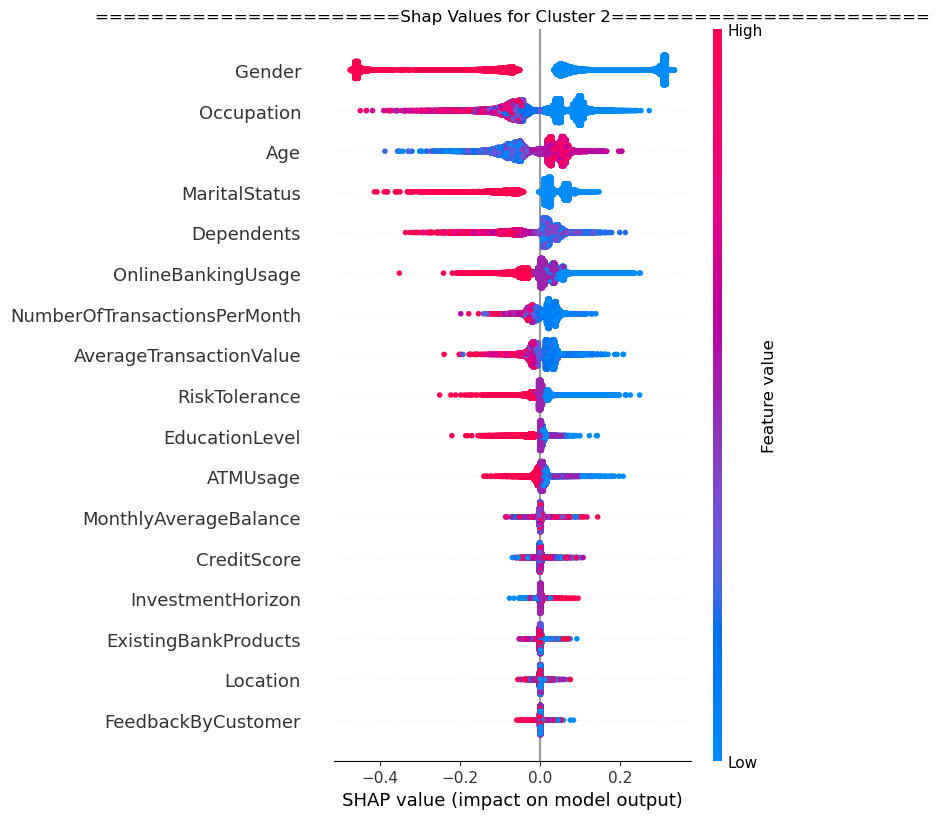

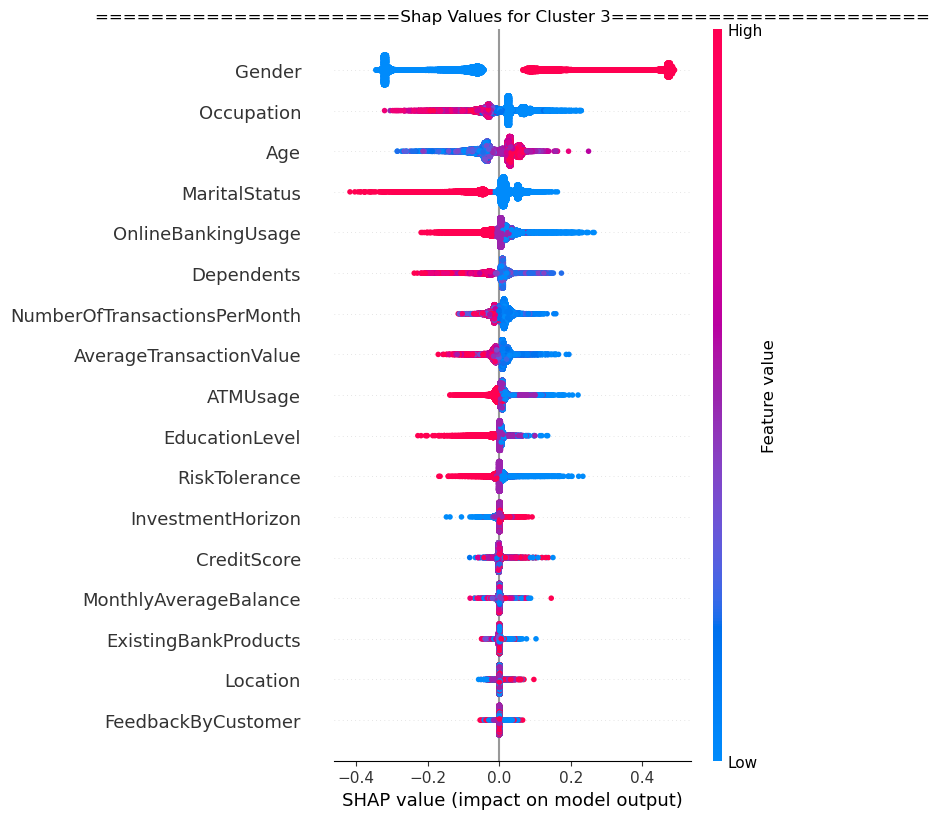

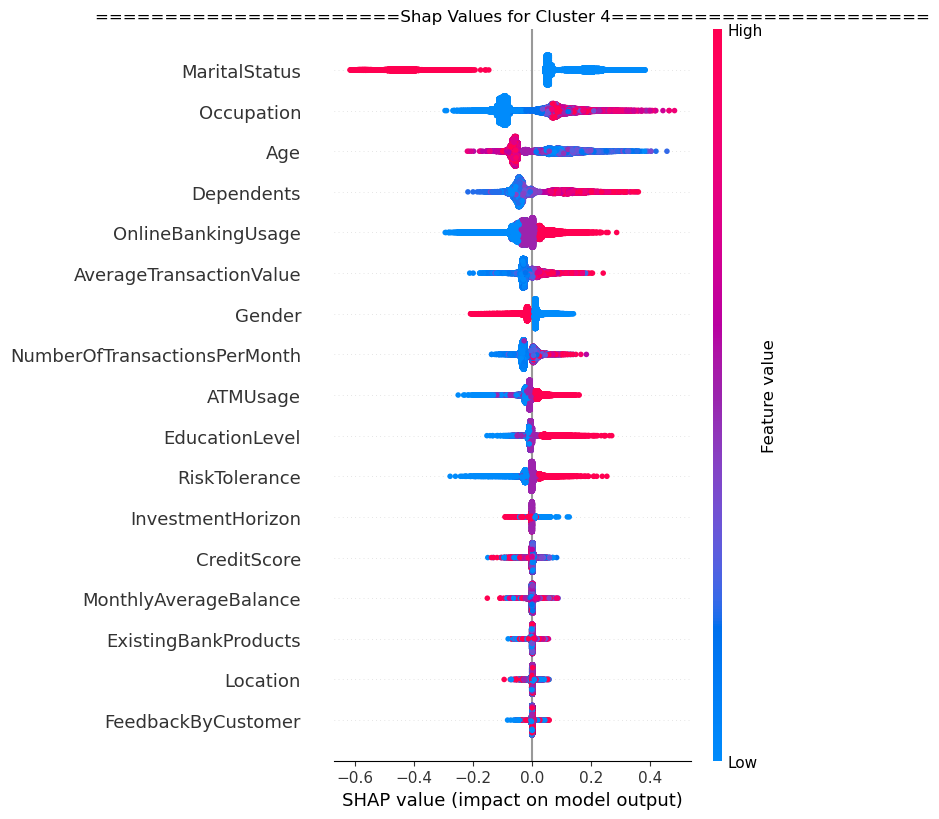

In [5]:
sa_df = df.sample(30000, random_state=30)

minscale = MinMaxScaler()
min_arr_sample = minscale.fit_transform(sa_df)
min_sample = pd.DataFrame(min_arr_sample, columns = df.columns)

kmeans_model = KMeans(n_clusters=4, random_state=30)
kmeans_model.fit(min_sample)
kmeans_model.cluster_centers_
sample_cluster = kmeans_model.predict(min_sample)
min_sample['Cluster_pred'] = sample_cluster

from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier (or any other classifier)
clf = RandomForestClassifier(n_estimators=5, random_state=30)
clf.fit(min_arr_sample, sample_cluster)

# Compute SHAP values
import shap 
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(min_arr_sample)

for cluster_indices, class_label in enumerate(['Cluster 1','Cluster 2','Cluster 3','Cluster 4']):
    plt.title(f'Shap Values for {class_label}'.center(70, '='))
    fig = shap.summary_plot(shap_values[:,:,cluster_indices], min_arr_sample, feature_names=std_sample.columns)
    plt.show()
    print('\n')
    plt.close()

### Plotting 2D graphs using important features derived from feature selection

In [ ]:
### Age vs MaritalStatus

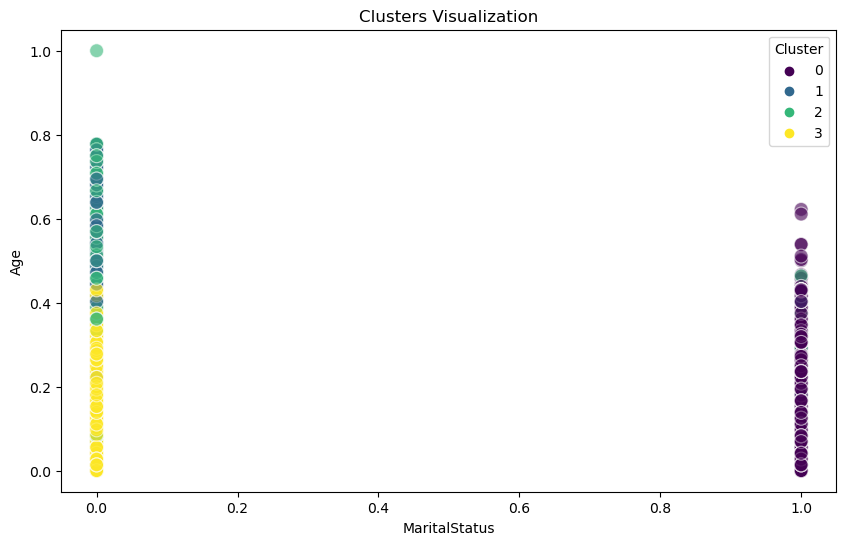

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature1 = 'MaritalStatus'
feature2 = 'Age'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature1, y=feature2, hue='Cluster_pred', palette='viridis', data=min_sample, s=100, alpha=0.6, edgecolor='w')
plt.title('Clusters Visualization')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend(title='Cluster')
plt.show()

In [ ]:
### Gender vs Age

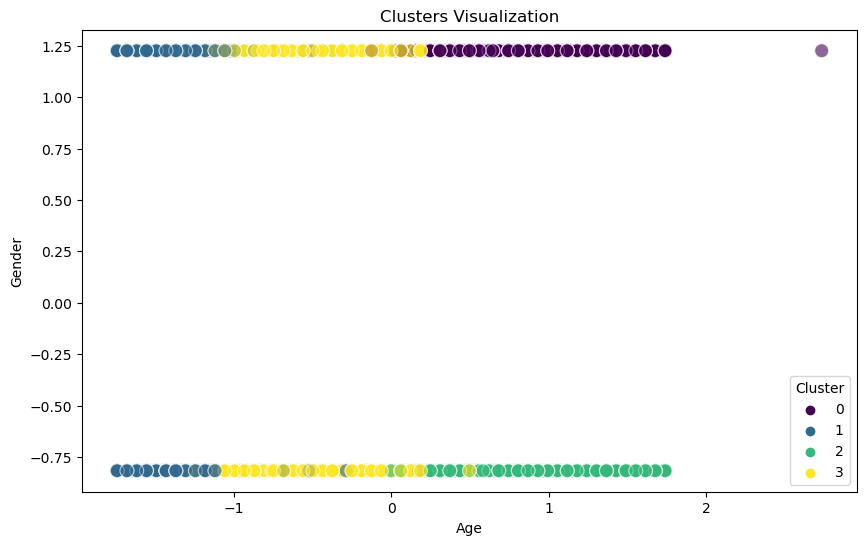

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature1 = 'Age'
feature2 = 'Gender'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature1, y=feature2, hue='Cluster_pred', palette='viridis', data=std_sample, s=100, alpha=0.6, edgecolor='w')
plt.title('Clusters Visualization')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend(title='Cluster')
plt.show()

In [ ]:
### Age vs Dependents

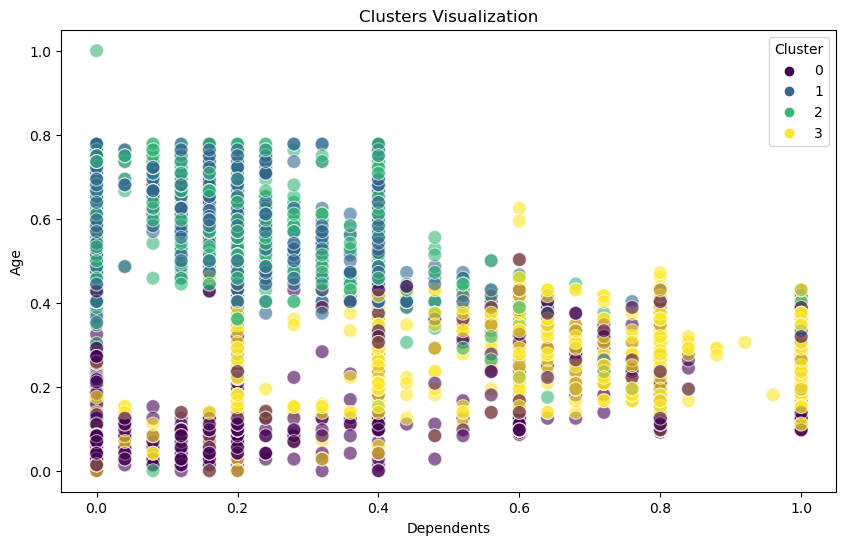

In [24]:
feature1 = 'Dependents'
feature2 = 'Age'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature1, y=feature2, hue='Cluster_pred', palette='viridis', data=min_sample, s=100, alpha=0.6, edgecolor='w')
plt.title('Clusters Visualization')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend(title='Cluster')
plt.show()

In [ ]:
------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
-----------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
### checking

In [59]:
checking = pd.read_csv('Preprocessed_df.csv')
checking.head()

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts
0,0.750000,0.4,0.433714,0.463678,0.069767,0.058672,0.0,0.0,0.333333,1.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.666667
1,0.083333,0.0,0.820000,0.449419,0.418605,0.360043,1.0,1.0,0.333333,0.0,0.333333,1.0,0.0,0.0,0.5,0.5,1.000000
2,0.583333,0.0,0.302857,0.352317,0.046512,0.055660,1.0,0.0,0.000000,0.0,0.000000,0.0,0.5,0.5,0.5,0.0,0.000000
3,0.472222,0.4,0.957143,0.078117,0.116279,0.214300,0.0,0.0,0.333333,1.0,0.000000,0.5,0.5,0.5,0.5,0.0,0.000000
4,0.152778,0.4,0.314286,0.045655,0.558140,0.378713,0.0,0.0,0.000000,1.0,0.833333,1.0,1.0,1.0,0.5,1.0,1.000000


In [66]:
checking.columns

Index(['Age', 'Dependents', 'CreditScore', 'MonthlyAverageBalance',
       'NumberOfTransactionsPerMonth', 'AverageTransactionValue', 'Gender',
       'MaritalStatus', 'EducationLevel', 'Location', 'Occupation',
       'OnlineBankingUsage', 'ATMUsage', 'InvestmentHorizon', 'RiskTolerance',
       'FeedbackByCustomer', 'ExistingBankProducts', 'check cluster'],
      dtype='object')

In [67]:
checking2 = checking[['Age', 'Dependents','NumberOfTransactionsPerMonth', 'Gender',
       'MaritalStatus','Occupation', 'ExistingBankProducts']]

In [60]:
kmeans_model = KMeans(n_clusters=4, random_state=30)
kmeans_model.fit(checking)
kmeans_model.cluster_centers_
check_cluster = kmeans_model.predict(checking)
checking['check cluster']= check_cluster
checking.head()

,Age,Dependents,CreditScore,MonthlyAverageBalance,NumberOfTransactionsPerMonth,AverageTransactionValue,Gender,MaritalStatus,EducationLevel,Location,Occupation,OnlineBankingUsage,ATMUsage,InvestmentHorizon,RiskTolerance,FeedbackByCustomer,ExistingBankProducts,check cluster
0,0.750000,0.4,0.433714,0.463678,0.069767,0.058672,0.0,0.0,0.333333,1.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.666667,3
1,0.083333,0.0,0.820000,0.449419,0.418605,0.360043,1.0,1.0,0.333333,0.0,0.333333,1.0,0.0,0.0,0.5,0.5,1.000000,0
2,0.583333,0.0,0.302857,0.352317,0.046512,0.055660,1.0,0.0,0.000000,0.0,0.000000,0.0,0.5,0.5,0.5,0.0,0.000000,1
3,0.472222,0.4,0.957143,0.078117,0.116279,0.214300,0.0,0.0,0.333333,1.0,0.000000,0.5,0.5,0.5,0.5,0.0,0.000000,3
4,0.152778,0.4,0.314286,0.045655,0.558140,0.378713,0.0,0.0,0.000000,1.0,0.833333,1.0,1.0,1.0,0.5,1.0,1.000000,2


In [62]:
checking['ExistingBankProducts'][checking['check cluster']== 0].value_counts()

ExistingBankProducts
0.000000    9471
0.666667    7821
1.000000    7816
0.333333    7726
Name: count, dtype: int64

In [63]:
checking['ExistingBankProducts'][checking['check cluster']== 1].value_counts()

ExistingBankProducts
0.000000    9582
0.333333    8050
0.666667    7937
1.000000    7894
Name: count, dtype: int64

In [64]:
checking['ExistingBankProducts'][checking['check cluster']== 2].value_counts()

ExistingBankProducts
0.000000    12641
0.333333    10380
0.666667    10252
1.000000    10198
Name: count, dtype: int64

In [65]:
checking['ExistingBankProducts'][checking['check cluster']== 3].value_counts()

ExistingBankProducts
0.000000    12991
0.666667    10790
0.333333    10680
1.000000    10664
Name: count, dtype: int64

In [69]:
kmeans_model2 = KMeans(n_clusters=4, random_state=30)
kmeans_model2.fit(checking2)
kmeans_model2.cluster_centers_
check_cluster2 = kmeans_model2.predict(checking2)
checking2['check cluster2']= check_cluster2
checking2.head()

,Age,Dependents,NumberOfTransactionsPerMonth,Gender,MaritalStatus,Occupation,ExistingBankProducts,check cluster2
0,0.750000,0.4,0.069767,0.0,0.0,0.000000,0.666667,2
1,0.083333,0.0,0.418605,1.0,1.0,0.333333,1.000000,0
2,0.583333,0.0,0.046512,1.0,0.0,0.000000,0.000000,1
3,0.472222,0.4,0.116279,0.0,0.0,0.000000,0.000000,2
4,0.152778,0.4,0.558140,0.0,0.0,0.833333,1.000000,3
